In [1]:
!pip install pot
!pip install ipdb #For debugging
!pip install tqdm #For the progress bar
!pip install numpy matplotlib tensorflow
!pip install jax jaxlib #Install jax and jaxlib, which stax depends on.
!pip install -U stax #Reinstall stax to ensure the latest version
!pip install --upgrade neural-tangents #Update neural-tangents

#Save requirements
#!pip freeze > requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 93.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 8.4 MB/s eta 0:00:00
  Created wheel for halo: filename=halo-0.0.31-py3-none-any.whl size=11232 sha256=860c3bd4b64b275c6b3145e22ebc5823044362b7567051b96234327de9d1f641
  Stored in directory: /root/.cache/pip/wheels/2e/b1/0a/62566170555f623c8327d47df1f53b6e4311ec9dd0ea70a99c
Successfully built halo
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.7/248.7 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 10.4 MB/s eta 0:00:00


Using device: cuda


NN widths:   0%|          | 0/8 [00:00<?, ?it/s]

Epochs > 0, using finite time GP mean and covariance with t=0.5.


NN widths:  12%|█▎        | 1/8 [00:24<02:48, 24.03s/it]

Width: 2, Scaled lr: 0.0005 W2 Distance: 1.8181
Epochs > 0, using finite time GP mean and covariance with t=0.25.


NN widths:  25%|██▌       | 2/8 [00:48<02:24, 24.14s/it]

Width: 4, Scaled lr: 0.00025 W2 Distance: 1.0655
Epochs > 0, using finite time GP mean and covariance with t=0.125.


NN widths:  38%|███▊      | 3/8 [01:12<02:00, 24.18s/it]

Width: 8, Scaled lr: 0.000125 W2 Distance: 0.6271
Epochs > 0, using finite time GP mean and covariance with t=0.0625.


NN widths:  50%|█████     | 4/8 [01:36<01:36, 24.22s/it]

Width: 16, Scaled lr: 6.25e-05 W2 Distance: 0.3896
Epochs > 0, using finite time GP mean and covariance with t=0.03125.


NN widths:  62%|██████▎   | 5/8 [02:02<01:14, 24.74s/it]

Width: 32, Scaled lr: 3.125e-05 W2 Distance: 0.2751
Epochs > 0, using finite time GP mean and covariance with t=0.015625.


NN widths:  75%|███████▌  | 6/8 [02:26<00:48, 24.50s/it]

Width: 64, Scaled lr: 1.5625e-05 W2 Distance: 0.2133
Epochs > 0, using finite time GP mean and covariance with t=0.0078125.


NN widths:  88%|████████▊ | 7/8 [02:51<00:24, 24.56s/it]

Width: 128, Scaled lr: 7.8125e-06 W2 Distance: 0.1977
Epochs > 0, using finite time GP mean and covariance with t=0.00390625.


NN widths: 100%|██████████| 8/8 [03:16<00:00, 24.56s/it]

Width: 256, Scaled lr: 3.90625e-06 W2 Distance: 0.1831
n_train=1, num_networks=10000, num_gp_samples=10000
num_test_inputs=1, epochs=1000, lr=0.001, activation=relu


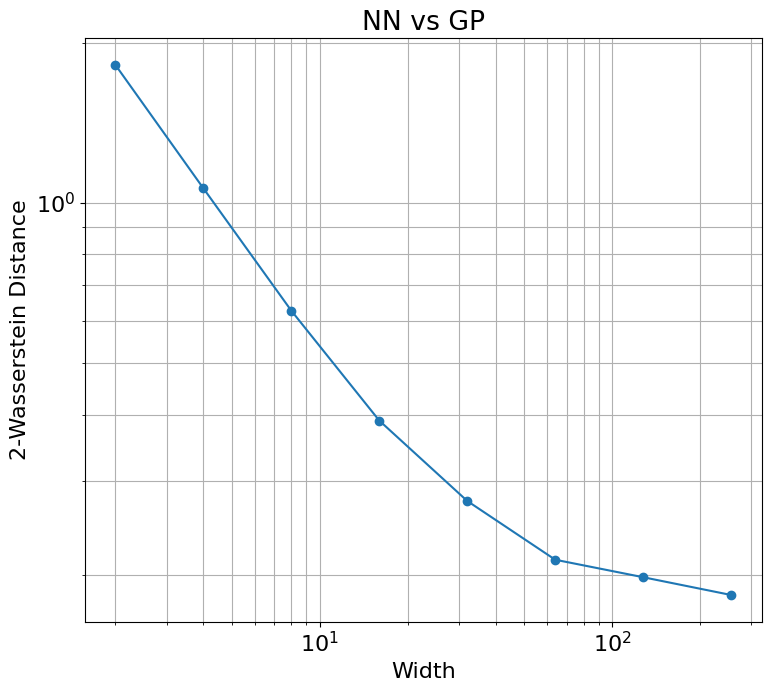

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import ot
import matplotlib.pyplot as plt
import scipy.linalg # Import scipy.linalg
import ipdb

import jax.numpy as jnp # Import JAX NumPy
import neural_tangents as nt # Import neural_tangents
from neural_tangents import stax

from tqdm import tqdm # Use standard tqdm, works in notebooks and scripts

# --- PyTorch Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Simulation parameters ---
num_networks = 10000  # Number of networks for empirical W2 (becomes batch size for PyTorch model)
num_gp_samples = 10000

# --- Training set, labels and test set ---
num_test_inputs = 1
n_train = 1
x_train_np = np.array([[1]], dtype=np.float32)
y_train_np = np.array([[2]], dtype=np.float32)
x_test_np = np.array([[2]], dtype=np.float32)

# --- Epochs, learning rate, activation, array of widths to test ---
epochs = 1000  # Set to > 0 for actual training
learning_rate = 0.001
activation_function = 'relu'  # 'relu' or 'erf', 'sigmoid', etc.
network_widths = [2, 4, 8, 16, 32, 64, 128, 256]
#network_widths = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048] # Added more for better plot
#network_widths = [20, 40, 80, 160, 320, 640]                      # We expect the result not to show for n1 > sqrt(num_networks) due to empirical wasserstein approximation error
#network_widths = [2,4,6,8,10]                                     # Small n1 to try with high time. For n1 this small 1000 samples should be enough
scaled_lrs = learning_rate / np.array(network_widths)              #Scaling as in [Lee et al. '19, Appendix G]

# --- PyTorch Batched Shallow NN ---
class BatchedShallowNN_Pytorch(nn.Module):
    def __init__(self, input_dim, hidden_units, num_parallel_networks, bias=False):
        super(BatchedShallowNN_Pytorch, self).__init__()
        self.num_parallel_networks = num_parallel_networks
        self.hidden_units = hidden_units
        # NTK Scaling factor
        self.ntk_scale = torch.sqrt(torch.tensor(hidden_units, dtype=torch.float32))

        # Set W_std and B_std based on the bias flag
        W_std = 1.0
        B_std = 1.0 if bias else 0.0

        # Parameters will have an extra dimension for num_parallel_networks
        # Layer 1 weights and biases
        self.w1 = nn.Parameter(torch.randn(num_parallel_networks, hidden_units, input_dim) * W_std)
        self.b1 = nn.Parameter(torch.randn(num_parallel_networks, hidden_units) * B_std)

        # Layer 2 weights and biases
        self.w2 = nn.Parameter(torch.randn(num_parallel_networks, 1, hidden_units) * W_std)
        self.b2 = nn.Parameter(torch.randn(num_parallel_networks, 1) * B_std)

        # Activation function selection
        if activation_function == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation_function == 'relu':
            self.activation = nn.ReLU()
        elif activation_function == 'erf':
            self.activation = torch.erf # Assign the function itself, not the result of calling it since its not an nn module

    def forward(self, x):
        # x has shape (batch_size_data, input_dim)
        # We want to process it with num_parallel_networks sets of weights

        # Expand x for batched matrix multiplication: (1, batch_size_data, input_dim)
        # Then allow broadcasting over num_parallel_networks dimension
        # Or more explicitly:
        # x_expanded: (num_parallel_networks, batch_size_data, input_dim)
        # self.w1:   (num_parallel_networks, hidden_units, input_dim)
        # self.b1:   (num_parallel_networks, hidden_units)

        # Hidden layer computation
        # (N, H, D_in) @ (B, D_in).T = (N, H, D_in) @ (D_in, B) -> (N, H, B)
        # N = num_parallel_networks, H = hidden_units, D_in = input_dim, B = batch_size_data
        hidden_lin = torch.einsum('nhd,bd->nhb', self.w1, x) + self.b1.unsqueeze(2) # unsqueeze for broadcasting over data batch
        hidden_act = self.activation(hidden_lin)

        # Output layer computation
        # (N, O, H) @ (N, H, B) -> (N, O, B) where O=1 (output_dim)
        outputs_lin = torch.einsum('noh,nhb->nob', self.w2, hidden_act) + self.b2.unsqueeze(2)

        # NTK Scaling
        outputs_scaled = outputs_lin / self.ntk_scale

        # Reshape to (num_parallel_networks, batch_size_data, output_dim)
        # Current shape is (num_parallel_networks, output_dim, batch_size_data)
        return outputs_scaled.transpose(1, 2)

# --- Train Batched PyTorch Networks ---
def train_batched_networks_pytorch(width, num_parallel_train_networks,
                                   x_train_np_local, y_train_np_local, x_test_np_local,
                                   epochs_local, lr_local, current_device, bias=False):

    model = BatchedShallowNN_Pytorch(input_dim=x_train_np_local.shape[1],
                                     hidden_units=width,
                                     num_parallel_networks=num_parallel_train_networks,
                                     bias=bias).to(current_device)

    x_train_torch = torch.from_numpy(x_train_np_local).float().to(current_device)
    y_train_torch = torch.from_numpy(y_train_np_local).float().to(current_device)
    x_test_torch = torch.from_numpy(x_test_np_local).float().to(current_device)

    if epochs_local > 0:
        optimizer = optim.SGD(model.parameters(), lr=lr_local)
        criterion = nn.MSELoss() # MSELoss typically averages over all elements

        # Expand y_train to match batched output shape: (num_parallel_networks, batch_size_data, output_dim)
        y_train_expanded = y_train_torch.unsqueeze(0).expand(num_parallel_train_networks, -1, -1)

        model.train()
        for epoch_idx in range(epochs_local):
            optimizer.zero_grad()
            outputs = model(x_train_torch) # Shape: (num_parallel, batch_data, out_dim)
            loss = criterion(outputs, y_train_expanded) # Will average over all N*B*O elements
            loss.backward()
            optimizer.step()

    # Get predictions
    model.eval()
    with torch.no_grad():
        predictions_batched = model(x_test_torch) # Shape: (num_parallel, batch_test_data, out_dim)

    # Return as numpy array, flatten last two dims if output_dim is 1, return also learning rates
    # Shape: (num_parallel_train_networks, num_test_inputs)
    return predictions_batched.cpu().numpy().reshape(num_parallel_train_networks, -1)

# --- It function (RECEIVES TIME ALREADY SCALED t = t*scaled_lr) ---
def It(k, t):
    # Add a small diagonal jitter to handle singularity
    k_reg = k + np.eye(k.shape[0]) * 1e-6

    # Solve linear system kX = I - e^{-kt}
    b_matrix = np.identity(k_reg.shape[0]) - scipy.linalg.expm(-k_reg * t) # Element-wise product for t if it's a scalar
    return np.linalg.solve(k_reg, b_matrix)

# --- GP Calculation (RECEIVES TIME ALREADY SCALED t = t*scaled_lr) ---
def GPcharacterization(time,x_train,x_test,y_train):
    # First create kernels
    # Width in stax.Dense is just a placeholder for NTK computation, doesn't affect the kernel value for infinite width limit
    # kernel_fn is stateless, so safe to define once
    # Select activation function for NTK computation
    if activation_function == 'sigmoid':
        init_fn, apply_fn, kernel_fn = stax.serial(
            stax.Dense(10, W_std=1.0, b_std=0.0), stax.Sigmoid_like(),
            stax.Dense(1, W_std=1.0, b_std=0.0)
        )
    elif activation_function == 'relu':
        init_fn, apply_fn, kernel_fn = stax.serial(
            stax.Dense(10, W_std=1.0, b_std=0.0), stax.Relu(),  # Use stax.Relu() for ReLU
            stax.Dense(1, W_std=1.0, b_std=0.0)
        )
    elif activation_function == 'erf':  # Using built-in stax.Erf
        init_fn, apply_fn, kernel_fn = stax.serial(
            stax.Dense(10, W_std=1.0, b_std=0.0), stax.Erf(),
            stax.Dense(1, W_std=1.0, b_std=0.0)
        )

    # Convert JAX arrays to NumPy for subsequent scipy/numpy operations if needed
    # kernel_fn returns JAX arrays. For operations like It or np.random.multivariate_normal,
    # ensure they are NumPy arrays. Often JAX arrays work, but explicit conversion is safer.
    k2_test_test_jax = kernel_fn(x_test, x_test, 'nngp')
    k2_test_train_jax = kernel_fn(x_test, x_train, 'nngp')
    k2_train_test_jax = kernel_fn(x_train, x_test, 'nngp')
    k2_train_train_jax = kernel_fn(x_train, x_train, 'nngp')

    kinf_test_train_jax = kernel_fn(x_test, x_train, 'ntk')
    kinf_train_train_jax = kernel_fn(x_train, x_train, 'ntk')

    # Convert JAX arrays to NumPy. .block_until_ready() is good practice for JAX before conversion.
    k2_test_test = np.array(k2_test_test_jax.block_until_ready())
    k2_test_train = np.array(k2_test_train_jax.block_until_ready())
    k2_train_test = np.array(k2_train_test_jax.block_until_ready())
    k2_train_train = np.array(k2_train_train_jax.block_until_ready())

    kinf_test_train = np.array(kinf_test_train_jax.block_until_ready())
    kinf_train_train = np.array(kinf_train_train_jax.block_until_ready())
    kinf_train_test = kinf_test_train.T

    # GP mean and covariance calculation

    if epochs == 0: # At initialization
        gp_mean = np.zeros_like(x_test @ y_train.T)
        gp_cov = k2_test_test
        print("Epochs = 0, using GP mean (0) and covariance (NNGP K(x_test,x_test)).")

    else: # epochs > 0
        Itk = It(kinf_train_train, time)
        gp_mean = kinf_test_train @ Itk @ y_train

        pz1 = k2_test_test
        pz2 = -k2_test_train @ Itk @ kinf_train_test
        pz3 = -kinf_test_train @ Itk @ k2_train_test
        pz4 = +kinf_test_train @ Itk @ k2_train_train @ Itk @ kinf_train_test
        gp_cov = pz1 + pz2 + pz3 + pz4
        print(f"Epochs > 0, using finite time GP mean and covariance with t={time}.")

    # Ensure gp_cov is positive semi-definite for sampling
    gp_cov = gp_cov + np.eye(gp_cov.shape[0]) * 1e-5

    return gp_mean, gp_cov

# --- Function to calculate W2 distance for a given network width ---
def calculate_w2_distance_pytorch(network_width_local, lr_local):
    # Train/evaluate batched networks and get dynamic learning rates
    nn_outputs = train_batched_networks_pytorch(
        width=network_width_local,
        num_parallel_train_networks=num_networks, # Global num_networks
        x_train_np_local=x_train_np,
        y_train_np_local=y_train_np,
        x_test_np_local=x_test_np,
        epochs_local=epochs, # Global epochs
        lr_local=lr_local, # Use the scaled learning rate
        current_device=device,
        bias=True # Choose bias
    )
    # nn_outputs shape: (num_networks, num_test_inputs)
    time = epochs*lr_local

    # Calculate GP mean and covariance
    gp_mean, gp_cov = GPcharacterization(time,x_train_np,x_test_np,y_train_np)

    # Sample the GP
    # gp_mean.flatten() because multivariate_normal expects 1D mean
    if gp_mean.ndim > 1 and gp_mean.shape[0] == num_test_inputs and gp_mean.shape[1] == 1 :
        gp_mean_flat = gp_mean.flatten()
    else: # Should be (num_test_inputs,)
        gp_mean_flat = gp_mean

    if num_test_inputs == 1 and gp_cov.ndim == 2 and gp_cov.shape == (1,1):
        # Special case for scalar output: multivariate_normal needs mean as (1,) and cov as (1,1)
        # If gp_cov is scalar, reshape
        gp_samples = np.random.normal(gp_mean_flat[0], np.sqrt(gp_cov[0,0]), size=(num_gp_samples, 1))
    elif num_test_inputs > 0 :
         gp_samples = np.random.multivariate_normal(gp_mean_flat, gp_cov, size=num_gp_samples)
         if num_test_inputs == 1 and gp_samples.ndim == 1: # If only one test input, result is (num_gp_samples,)
            gp_samples = gp_samples.reshape(-1,1) # Reshape to (num_gp_samples, 1)
    else: # num_test_inputs == 0, should not happen with valid x_test
        gp_samples = np.array([]).reshape(num_gp_samples,0)

    # Compute W2 distance between NN and GP using POT
    if num_test_inputs == 0:
        return 0.0 # Or handle as an error/special case

    a = np.ones((num_networks,)) / num_networks
    b = np.ones((num_gp_samples,)) / num_gp_samples

    cost_matrix = ot.dist(nn_outputs, gp_samples, metric='sqeuclidean') # POT uses squared Euclidean for W2^2
    # W2_squared = ot.emd2(a, b, cost_matrix, numItermax=200000) # Sinkhorn might be faster for large N,M
    W2_squared = ot.emd2(a, b, cost_matrix,numItermax=200000)

    if W2_squared < 0: # Numerical precision might lead to tiny negative
        print(f"Warning: W2_squared is {W2_squared}, clamping to 0.")
        W2_squared = 0.0
    W2 = np.sqrt(W2_squared)

    return W2

# --- Main Loop ---
# Train and calculate W2 distance with chosen activation
w2_distances = []
for i, width_val in tqdm(enumerate(network_widths), total=len(network_widths), desc="NN widths"):
    lr_val = scaled_lrs[i]
    w2_dist = calculate_w2_distance_pytorch(width_val,lr_val)
    w2_distances.append(w2_dist)
    print(f"Width: {width_val}, Scaled lr: {lr_val} W2 Distance: {w2_dist:.4f}")

# --- Plotting ---
font = 16   #Choice of font size
#plt.figure(figsize=(10, 6))
plt.figure(figsize=(8, 8))  # Creates an 8x8 inch squared figure
plt.rcParams.update({'font.size': font})  # Adjust the font size as desired
plt.plot(network_widths, w2_distances, marker='o')
plt.xlabel('Width', fontsize=font)
plt.ylabel('2-Wasserstein Distance', fontsize=font)
plt.title('NN vs GP')

plt.xscale('log')
plt.yscale('log')

param_info = f"n_train={n_train}, num_networks={num_networks}, num_gp_samples={num_gp_samples}\n" \
             f"num_test_inputs={num_test_inputs}, epochs={epochs}, lr={learning_rate}, activation={activation_function}"
#plt.figtext(0.5, 0.01, param_info, ha='center', fontsize=8, wrap=True)
print(param_info)
plt.grid(True, which="both", ls="-") # Grid for log scales
plt.tight_layout(rect=[0, 0.1, 1, 1]) # Adjust layout to make space for figtext
plt.show()